In [1]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output

In [2]:
# Callback invoked by the IPython interact method for scrolling through image stacks of
# the two images being registered.
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
%%time

# Paths to fixed and moving 3D images
xy_um = 14.4 * 2
z_um = 16.0 * 2
reg_path = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'
fixed_image_path = os.path.join(reg_path, 'Allen', f'Allen_{z_um}x{xy_um}x{xy_um}um_sagittal.tif')
moving_image_path = os.path.join(reg_path, 'ALLEN771602', f'ALLEN771602_{z_um}x{xy_um}x{xy_um}um_sagittal.tif')

CPU times: user 9 µs, sys: 11 µs, total: 20 µs
Wall time: 23.6 µs


In [4]:
fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

In [5]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

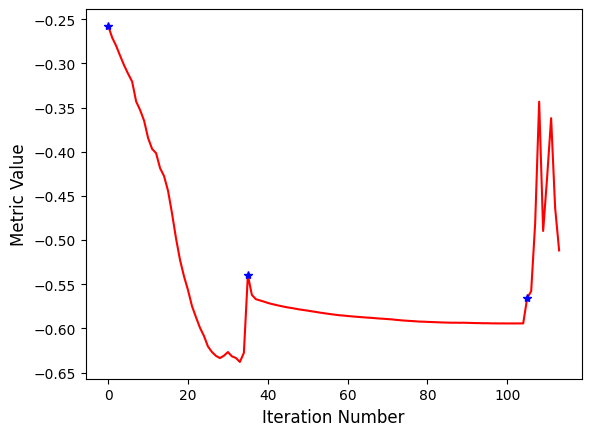

In [6]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1,
    numberOfIterations=300,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [7]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

Final metric value: -0.5464171259857015
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [ ]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

interact(
    display_images_with_alpha,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(fixed_image),
    moving=fixed(moving_resampled),
);

In [ ]:
transformed_moving = sitk.TransformGeometry(moving_image, final_transform)
print(
    f"origin before: {moving_image.GetOrigin()}\norigin after: {transformed_moving.GetOrigin()}"
)
print(
    f"direction cosine before: {moving_image.GetDirection()}\ndirection cosine after: {transformed_moving.GetDirection()}"
)